In [21]:
import $file.scripts.importer

importer.loadProjectDependencies

Compiling importer.sc


import $file.$               



In [22]:
import smile.read
import smile.plot._
import smile.util._
import smile.math._, Math._

import smile.data._
import smile.interpolation._
import smile.validation._
import smile.manifold._
import smile.mds._
import smile.projection._

import scala.collection.JavaConverters._
import scala.collection.JavaConversions._
import edu.stanford.math.plex4._
import edu.stanford.math.plex4.api._
import edu.stanford.math.plex4.visualization._
import edu.stanford.math.plex4.homology.barcodes._
import edu.stanford.math.plex4.streams.impl.LazyWitnessStream

import breeze.numerics._
import breeze.linalg._
import breeze.math._
import breeze.stats.{mean, stddev}
import breeze.util.JavaArrayOps

import tda.persistence.Analysis._
import tda.persistence.Math._

def drawBarcodes(images: Seq[java.awt.image.BufferedImage]) = {
  images foreach publish.png 
}

val maxDimension = 3
lazy val persistence = Plex4.getModularSimplicialAlgorithm(maxDimension, 2)

def lazyStreamIntervalsWithImages(data: Array[Array[Double]], scale: Double) = {
  val noLandmarkPoints = 50
  val numDivisions = 100 

  lazy val landmarkSelector = Plex4
    .createMaxMinSelector(data, noLandmarkPoints)

  lazy val landmarkIndices = landmarkSelector.getLandmarkPoints()

  val D = landmarkSelector.getMaxDistanceFromPointsToLandmarks 

  lazy val filtrationValue = scale * D  

  lazy val patchesLandmarksStream = new LazyWitnessStream(
    landmarkSelector.getUnderlyingMetricSpace,
    landmarkSelector,
    maxDimension,
    filtrationValue,
    1,
    numDivisions)

  patchesLandmarksStream.finalizeStream()
  
  (
    patchesLandmarksStream.getSize,
    filtrationValue,
    intervalsWithImages(
      patchesLandmarksStream,
      maxDimension,
      filtrationValue,
      persistence)  
  )
}

import smile.read

import smile.plot._

import smile.util._

import smile.math._, Math._


import smile.data._

import smile.interpolation._

import smile.validation._

import smile.manifold._

import smile.mds._

import smile.projection._


import scala.collection.JavaConverters._

import scala.collection.JavaConversions._

import edu.stanford.math.plex4._

import edu.stanford.math.plex4.api._

import edu.stanford.math.plex4.visualization._

import edu.stanford.math.plex4.homology.barcodes._

import edu.stanford.math.plex4.streams.impl.LazyWitnessStream


import breeze.numerics._

import breeze.linalg._

import breeze.math._

import breeze.stats.{mean, stddev}

import breeze.util.JavaArrayOps


import tda.persistence.Analysis._

import tda.persistence.Math._


defined function drawBarcodes
maxDimension: Int = 3
persistence: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = <lazy>
defined function lazyStreamIntervalsWithImages

# Natural image patches
idea for analysis and dataset comes from [On the Local Behavior of Spaces of Natural Images](http://math.uchicago.edu/~shmuel/AAT-readings/Data%20Analysis%20/mumford-carlsson%20et%20al.pdf)

(points15 is X(15, 30) from the paper)

In [23]:
lazy val points15 = read.csv("../data/pointsDct15.csv").unzip

points15: Array[Array[Double]] = <lazy>

In [24]:
lazy val (patchesStreamSize, filtrationValue, (_, patchesLandmarkImages))= lazyStreamIntervalsWithImages(points15, 1)

patchesStreamSize: Int = <lazy>
filtrationValue: Double = <lazy>
patchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Image patches stream for
maxFiltrationValue = 0.631618418066971
has 111354 simplices


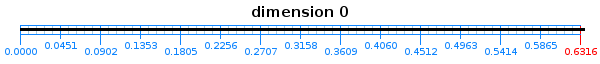

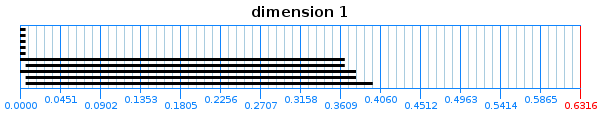

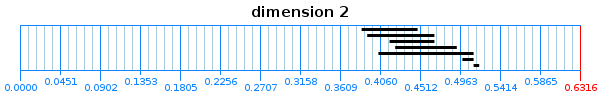

In [41]:
println(Seq(
  "Image patches stream for",
  s"maxFiltrationValue = ${filtrationValue}",
  s"has ${patchesStreamSize} simplices").mkString("\n"))

drawBarcodes(patchesLandmarkImages)

# Sampling

In [26]:
val subsampledPoints15 = subsampleByMaxmin(1000, points15)

subsampledPoints15: Array[Array[Double]] = Array(
  Array(
    0.2990812070675308,
    0.6505974885035433,
    0.018337503848938383,
    0.4944996249489618,
    0.43589451105142724,
    0.22178973518432335,
    -0.05549065998365506,
    -0.011546457500050233
  ),
  Array(
...

In [27]:
lazy val (sampledPatchesStreamSize, sampledFiltrationValue, (_, sampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(subsampledPoints15, 0.7)

sampledPatchesStreamSize: Int = <lazy>
sampledFiltrationValue: Double = <lazy>
sampledPatchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Sampled image patches stream for
maxFiltrationValue = 0.4434996477448431
has 16980 simplices

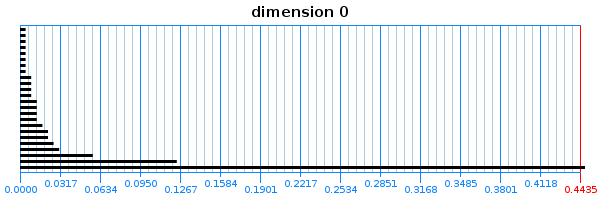

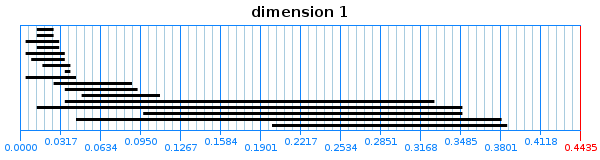

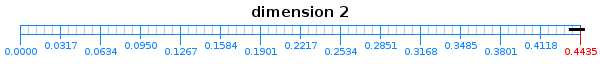

In [42]:
println(Seq(
  "Sampled image patches stream for",
  s"maxFiltrationValue = ${sampledFiltrationValue}",
  s"has ${sampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(sampledPatchesLandmarkImages)

## Isomap 

In [29]:
val isomap_ = isomap(subsampledPoints15, d = 3, k = 6)
lazy val isomapReducedData = isomap_.getCoordinates

isomap_: IsoMap = smile.manifold.IsoMap@c92d326
isomapReducedData: Array[Array[Double]] = <lazy>

In [30]:
lazy val (isomapSampledPatchesStreamSize, isomapSampledFiltrationValue, (_, isomapSampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(isomapReducedData, 1)

isomapSampledPatchesStreamSize: Int = <lazy>
isomapSampledFiltrationValue: Double = <lazy>
isomapSampledPatchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Image patches reduced by Isomap stream for
maxFiltrationValue = 2.0486544279447765
has 2445 simplices

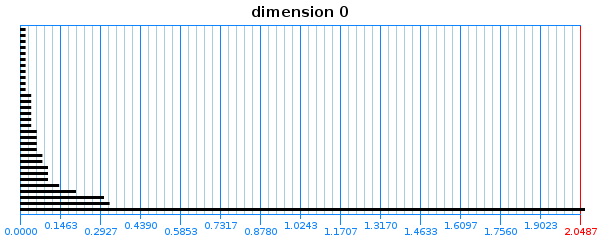

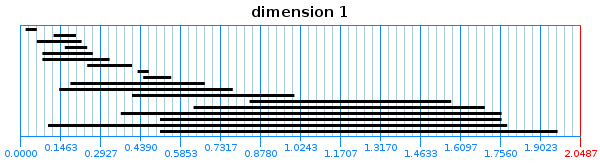

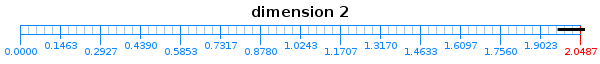

In [43]:
println(Seq(
  "Image patches reduced by Isomap stream for",
  s"maxFiltrationValue = ${isomapSampledFiltrationValue}",
  s"has ${isomapSampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(isomapSampledPatchesLandmarkImages)

## LLE ($d$ = 3)

In [32]:
val lle_ = lle(subsampledPoints15, d = 3, k = 5)
lazy val lleReducedData = lle_.getCoordinates

lle_: LLE = smile.manifold.LLE@8d61135
lleReducedData: Array[Array[Double]] = <lazy>

In [33]:
lazy val (lleSampledPatchesStreamSize, lleSampledFiltrationValue, (_, lleSampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(lleReducedData, 3)

lleSampledPatchesStreamSize: Int = <lazy>
lleSampledFiltrationValue: Double = <lazy>
lleSampledPatchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Image patches reduced by LLE for
maxFiltrationValue = 0.06501768640093862
has 87278 simplices

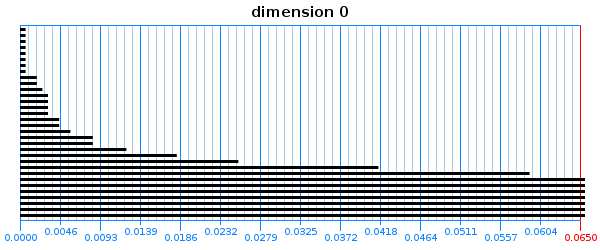

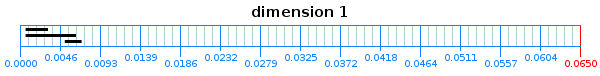

In [44]:
println(Seq(
  "Image patches reduced by LLE for",
  s"maxFiltrationValue = ${lleSampledFiltrationValue}",
  s"has ${lleSampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(lleSampledPatchesLandmarkImages)

## LLE ($d$ = 4)

In [35]:
val lle4_ = lle(subsampledPoints15, d = 4, k = 4)
lazy val lle4ReducedData = lle_.getCoordinates

lle4_: LLE = smile.manifold.LLE@4eeb28e8
lle4ReducedData: Array[Array[Double]] = <lazy>

In [36]:
lazy val (lle4SampledPatchesStreamSize, lle4SampledFiltrationValue, (_, lle4SampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(lle4ReducedData, 2)

lle4SampledPatchesStreamSize: Int = <lazy>
lle4SampledFiltrationValue: Double = <lazy>
lle4SampledPatchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Image patches reduced by LLE stream for
maxFiltrationValue = 0.06264307047454934
has 79525 simplices


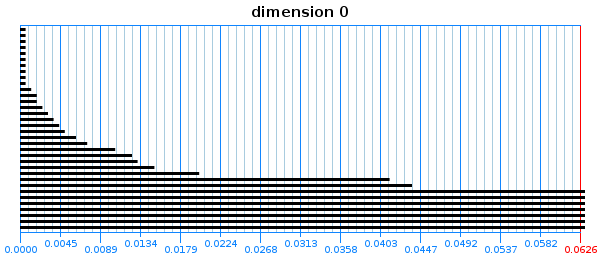

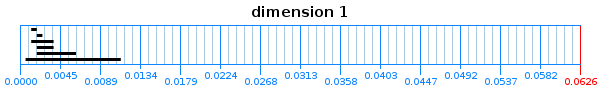

In [45]:
println(Seq(
  "Image patches reduced by LLE stream for",
  s"maxFiltrationValue = ${lle4SampledFiltrationValue}",
  s"has ${lle4SampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(lle4SampledPatchesLandmarkImages)

## KPCA

In [38]:
val kpca_ = kpca(subsampledPoints15, new kernel.PolynomialKernel(2, 2.0, 1.0), k = 3)
lazy val kpcaReducedData = kpca_.getCoordinates

kpca_: KPCA[Array[Double]] = smile.projection.KPCA@17373709
kpcaReducedData: Array[Array[Double]] = <lazy>

In [39]:
lazy val (lle4SampledPatchesStreamSize, lle4SampledFiltrationValue, (_, lle4SampledPatchesLandmarkImages))= lazyStreamIntervalsWithImages(lle4ReducedData, 3)

lle4SampledPatchesStreamSize: Int = <lazy>
lle4SampledFiltrationValue: Double = <lazy>
lle4SampledPatchesLandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

Image patches (reduced by polynomial kernel KPCA) stream for
maxFiltrationValue = 0.06264307047454934
has 79525 simplices

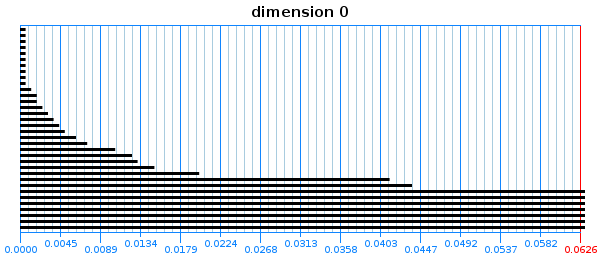

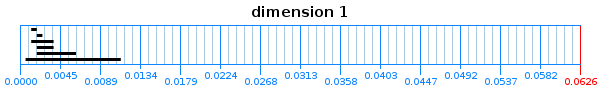

In [46]:
println(Seq(
  "Image patches (reduced by polynomial kernel KPCA) stream for",
  s"maxFiltrationValue = ${lle4SampledFiltrationValue}",
  s"has ${lle4SampledPatchesStreamSize} simplices").mkString("\n"))

drawBarcodes(lle4SampledPatchesLandmarkImages)